In [1]:
from glob import glob
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from tqdm import tqdm
import scipy
import sys
import torch
sys.path.insert(0,"/study/mrphys/skunkworks/kk/mriUnet")
from smoothing import GaussianSmoothing
import scipy
import seaborn as sns
sns.set()

In [72]:
def readT1(file):
    if file.endswith(".npy"):
        return np.load(file)[0]
    elif file.endswith(".nii"):
        return np.transpose(nib.load(file).get_fdata())/1000
    else:
        return None
    
dataset = {
    "pred":{
        "Accelerated DL" : sorted(glob("/study/mrphys/skunkworks/kk/T1/T1_2min_*.npy")) ,
        "Full DL": sorted(glob("/study/mrphys/skunkworks/kk/T1/T1_gt_*.npy")),
        "Denoised DL": sorted([file for file in glob("/study/mrphys/skunkworks/kk/T1/T1_*.npy") if (not(file in T1_9min_dl_list_path) and not(file in T1_2min_dl_list_path))]),
        "Accelerated GT" : sorted(glob("/study/mrphys/skunkworks/training_data/mover01/*/processed_data/acc_2min/T1_3_tv.nii"))
    },
    "true": sorted(glob("/study/mrphys/skunkworks/training_data/mover01/*/processed_data/T1_3_tv.nii")),
    "mask": sorted(glob('/scratch/mrphys/masks/*')),
}
    
def emptyDict(dataset=dataset):
    dictionary = {
        "pred" : {
            pred:[] for pred in dataset["pred"].keys()
        },
        "true":[]
    }
    return dictionary

In [73]:
T1Dict = {
    "Whole Brain" : emptyDict(),
    "Gray Matter" : emptyDict(),
    "White Matter" : emptyDict(),
} 

for i in tqdm(range(len(dataset["true"]))):
    ground_truth = readT1(dataset["true"][i])
    mask = np.load(dataset["mask"][i])
    T1Dict["Whole Brain"]["true"].append(np.mean(ground_truth[mask!=0]))
    T1Dict["Gray Matter"]["true"].append(np.mean(ground_truth[mask==2]))
    T1Dict["White Matter"]["true"].append(np.mean(ground_truth[mask==3]))
    for pred in dataset["pred"].keys():
        predictions = readT1(dataset["pred"][pred][i])
        T1Dict["Whole Brain"]["pred"][pred].append(np.mean(predictions[mask!=0]))
        T1Dict["Gray Matter"]["pred"][pred].append(np.mean(predictions[mask==2]))
        T1Dict["White Matter"]["pred"][pred].append(np.mean(predictions[mask==3]))

100%|███████████████████████████████████████████████████████████████████████████████████| 65/65 [00:54<00:00,  1.18it/s]


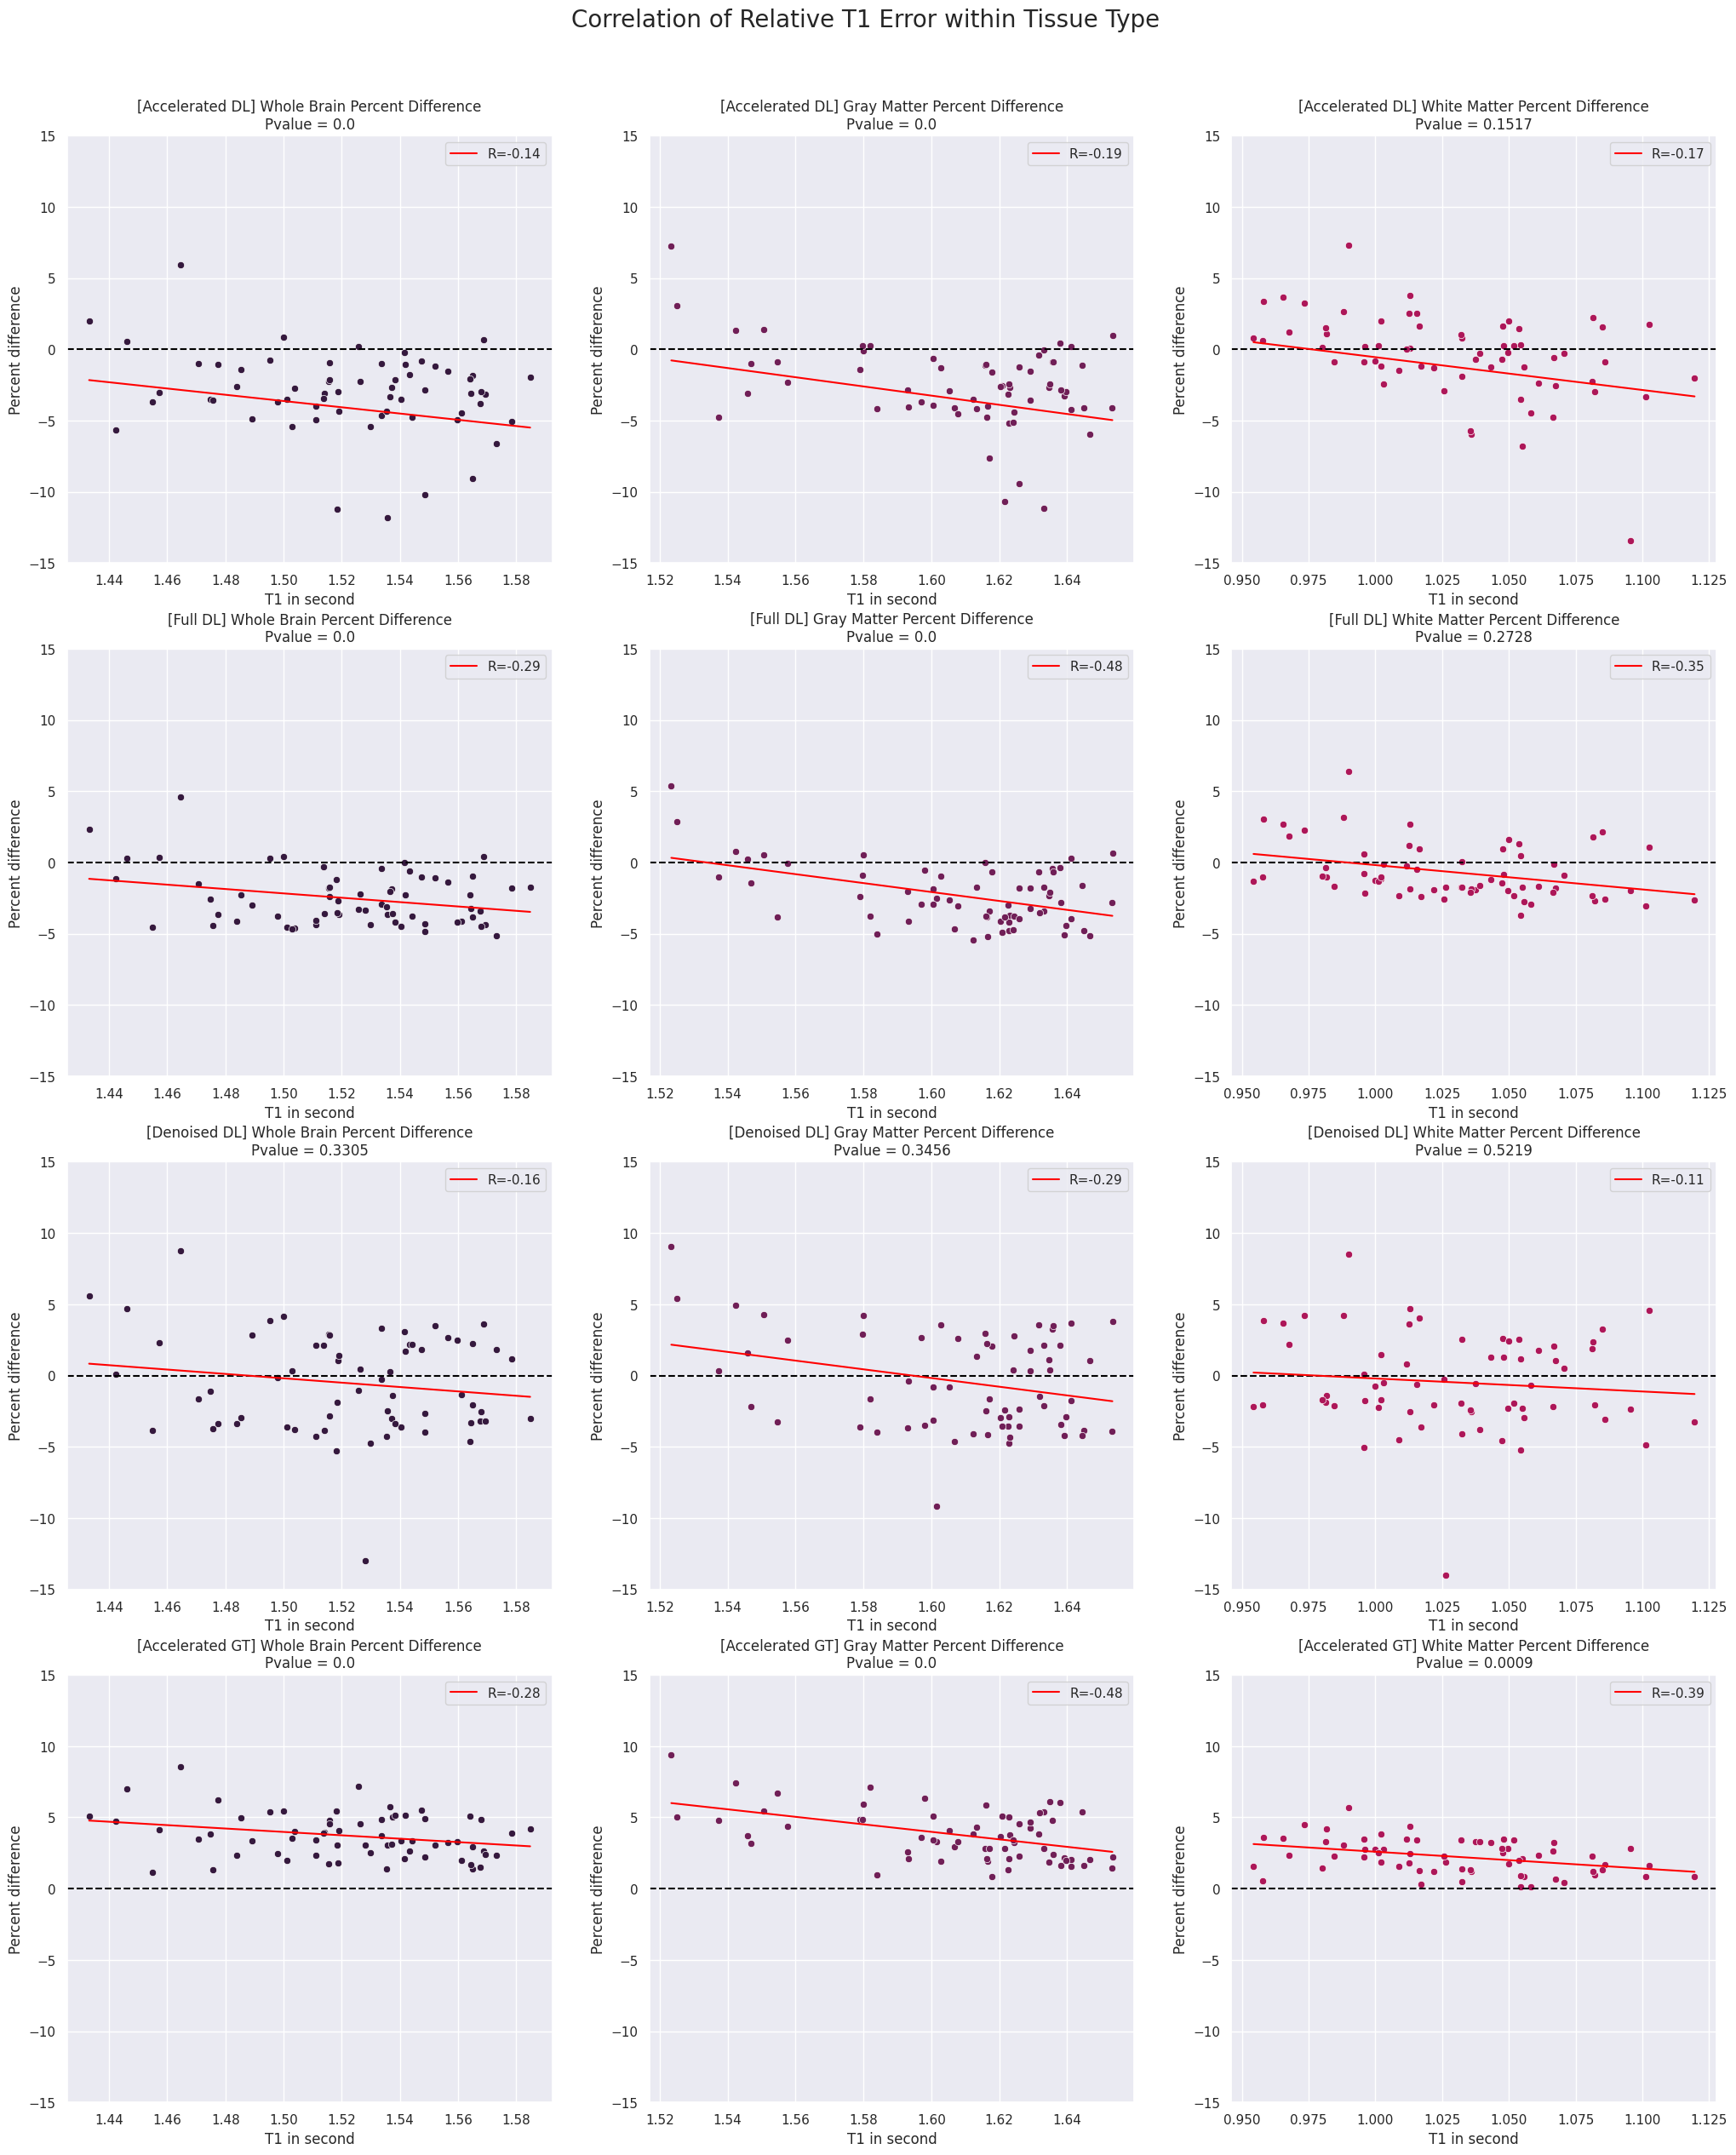

In [75]:
n = len(emptyDict()["pred"].keys())

fig, ax = plt.subplots(n, 3, figsize=(25, int(23*n/3)))
colors = sns.color_palette("rocket")

for i, name in enumerate(T1Dict.keys()):
    
    true = T1Dict[name]["true"]
    
    for j, scantype in enumerate(T1Dict[name]["pred"].keys()):
        
        pred = T1Dict[name]["pred"][scantype]
        percent_dif = 100*(np.array(pred)-np.array(true))/np.array(true)
        m, c, r, p, std_err = scipy.stats.linregress(true, percent_dif)
        x = np.linspace(np.min(true), np.max(true), 100)
        y = m*x+c
        
        ax[j,i].axhline(0, linestyle="--", color='black')
        ax[j,i].set_title(f'[{scantype}] {name} Percent Difference\nPvalue = {round(scipy.stats.f_oneway(pred, true)[1], 4)}')
        sns.scatterplot(ax=ax[j,i], x=true, y=percent_dif, color=colors[i])
        ax[j,i].set_xlabel('T1 in second') 
        ax[j,i].set_ylabel('Percent difference')
        ax[j,i].set_ylim([-15, 15])
        ax[j,i].plot(x, y, color = 'red', label=f'R={round(r, 2)}')
        ax[j,i].legend()
    
fig.suptitle("Correlation of Relative T1 Error within Tissue Type", fontsize=20, y=0.93)
plt.show()

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(25, 23))
colors = sns.color_palette("rocket")

T1Dict = {
    "Whole Brain" : {
        "pred" : {
            "Accelerated" :wb_2min_dl,
            "Full":wb_9min_dl,
            "Denoised":wb_denoised_dl
        },
        "true" : wb_gt
    },
    "Gray Matter" : {
        "pred" : {
            "Accelerated" :gm_2min_dl,
            "Full":gm_9min_dl,
            "Denoised":gm_denoised_dl
        },
        "true" : gm_gt
    },
    "White Matter" : {
        "pred" : {
            "Accelerated" :wm_2min_dl,
            "Full":wm_9min_dl,
            "Denoised":wm_denoised_dl
        },
        "true" : wm_gt
    },
}

for i, name in enumerate(T1Dict.keys()):
    
    true = T1Dict[name]["true"]
    
    for j, scantype in enumerate(T1Dict[name]["pred"].keys()):
        
        pred = T1Dict[name]["pred"][scantype]
        percent_dif = 100*(np.array(pred)-np.array(true))/np.array(true)
        m, c, r, p, std_err = scipy.stats.linregress(true, percent_dif)
        x = np.linspace(np.min(true), np.max(true), 100)
        y = m*x+c
        
        ax[j,i].axhline(0, linestyle="--", color='black')
        ax[j,i].set_title(f'[{scantype} DL] {name} Percent Difference\nPvalue = {round(scipy.stats.f_oneway(pred, true)[1], 4)}')
        sns.scatterplot(ax=ax[j,i], x=true, y=percent_dif, color=colors[i])
        ax[j,i].set_xlabel('T1 in second') 
        ax[j,i].set_ylabel('Percent difference')
        ax[j,i].set_ylim([-0.25, 0.25])
        ax[j,i].plot(x, y, color = 'red', label=f'R2={round(r, 2)}')
        ax[j,i].legend()
    
fig.suptitle("Correlation of Absolute T1 Error within Tissue Type", fontsize=20, y=0.93)
plt.show()

In [92]:
#smoothening
gpu_id = 'cuda'
smoother = GaussianSmoothing(1, 10, 0.2, 3).to(gpu_id)
def smoothen(pred, mask):
    e = np.copy(pred)
    e[np.expand_dims(mask, 0)==0] = 0.0
    e = smoother(torch.tensor(e).float().to(gpu_id))
    return e.cpu().numpy()

In [111]:
pvalue_2min = []
pvalue_9min = []

T1_2min_dl_list_path = sorted(glob("/study/mrphys/skunkworks/kk/T1/T1_*.npy"))
T1_9min_dl_list_path = sorted(glob("/study/mrphys/skunkworks/kk/T1/T1_gt_*.npy"))
gt_list_path = sorted(glob("/study/mrphys/skunkworks/training_data/mover01/*/processed_data/T1_3_tv.nii"))
mask_list_path = sorted(glob('/scratch/thuwajit/mask/*'))

for i, (dl2, dl9, gt, m) in tqdm(enumerate(zip(T1_2min_dl_list_path, T1_9min_dl_list_path , gt_list_path, mask_list_path))):
    mask = np.load(m)
    
    t1_2min_dl = smoothen(np.load(dl2), mask)[0]
    t1_9min_dl = smoothen(np.load(dl9), mask)[0]
    ground_truth = smoothen(np.expand_dims(np.transpose(nib.load(gt).get_fdata())/1000,0), mask)[0]
    
    wb_pvalue = scipy.stats.f_oneway(t1_2min_dl[mask!=0], ground_truth[mask!=0])[1]
    gm_pvalue = scipy.stats.f_oneway(t1_2min_dl[mask==2], ground_truth[mask==2])[1]
    wm_pvalue = scipy.stats.f_oneway(t1_2min_dl[mask==3], ground_truth[mask==3])[1]
    
    pvalue_2min.append([wb_pvalue,gm_pvalue,wm_pvalue])
    
    wb_pvalue = scipy.stats.f_oneway(t1_9min_dl[mask!=0], ground_truth[mask!=0])[1]
    gm_pvalue = scipy.stats.f_oneway(t1_9min_dl[mask==2], ground_truth[mask==2])[1]
    wm_pvalue = scipy.stats.f_oneway(t1_9min_dl[mask==3], ground_truth[mask==3])[1]
    
    pvalue_9min.append([wb_pvalue,gm_pvalue,wm_pvalue])
    
    diff = t1_2min_dl[mask==cond]-ground_truth[mask==cond]
    percent_diff = (t1_2min_dl[mask==cond]-ground_truth[mask==cond])/ground_truth[mask==cond]
    
    print(f'Subject {i}')

    print(np.mean(diff)*1000, np.std(diff)*1000)
    print(np.mean(percent_diff)*100, np.std(percent_diff)*100)

1it [00:02,  2.09s/it]

Subject 0
7.956653833389282 59.87124890089035
0.658396678045392 4.984109476208687


2it [00:03,  1.95s/it]

Subject 1
29.61954101920128 78.10857146978378
2.512877993285656 6.395719200372696


3it [00:05,  1.90s/it]

Subject 2
35.01297906041145 65.79551845788956
3.4902919083833694 5.903490632772446


4it [00:07,  1.88s/it]

Subject 3
-161.09035909175873 182.23296105861664
-15.925857424736023 18.105149269104004


5it [00:09,  1.96s/it]

Subject 4
-26.147296652197838 49.25752058625221
-2.502080239355564 4.423908889293671


6it [00:11,  1.92s/it]

Subject 5
-33.058784902095795 61.2814761698246
-2.8540031984448433 5.056632310152054


7it [00:13,  1.89s/it]

Subject 6
-29.10890243947506 60.02595275640488
-2.577926777303219 4.944916814565659


8it [00:15,  1.88s/it]

Subject 7
-22.879643365740776 57.22486227750778
-2.2754816338419914 5.114042013883591


9it [00:17,  1.87s/it]

Subject 8
-8.389802649617195 75.47952234745026
-0.9161798283457756 6.375550478696823


10it [00:18,  1.87s/it]

Subject 9
38.65920752286911 69.14550065994263
3.762204200029373 6.069059297442436


11it [00:20,  1.87s/it]

Subject 10
-0.5036661168560386 95.21558880805969
0.000982424353423994 7.952810078859329


12it [00:22,  1.87s/it]

Subject 11
21.98908105492592 60.49058213829994
1.8997877836227417 5.147366225719452


13it [00:24,  1.93s/it]

Subject 12
80.71303367614746 109.29815471172333
8.025752007961273 10.188131779432297


14it [00:26,  1.94s/it]

Subject 13
-49.18855428695679 49.20458421111107
-4.6311043202877045 4.161657020449638


15it [00:28,  1.93s/it]

Subject 14
22.039957344532013 57.937249541282654
2.0695677027106285 4.9860745668411255


16it [00:30,  1.93s/it]

Subject 15
-32.43647143244743 60.656338930130005
-2.9236435890197754 5.019192025065422


17it [00:32,  1.92s/it]

Subject 16
-39.618656039237976 57.80741199851036
-3.566357120871544 4.876720160245895


18it [00:34,  2.01s/it]

Subject 17
40.72127863764763 63.774846494197845
3.9912842214107513 5.666894465684891


19it [00:36,  1.97s/it]

Subject 18
39.86498340964317 62.01263144612312
3.8848623633384705 5.521519109606743


20it [00:38,  1.93s/it]

Subject 19
8.04336741566658 61.733178794384
0.7293814793229103 5.221927165985107


21it [00:40,  1.95s/it]

Subject 20
-24.331796914339066 49.04872924089432
-2.2894958034157753 4.447891563177109


22it [00:42,  1.93s/it]

Subject 21
-30.871901661157608 58.05463343858719
-2.934401296079159 5.004256963729858


23it [00:44,  1.92s/it]

Subject 22
-8.907598443329334 60.98400801420212
-0.8498969487845898 5.353948846459389


24it [00:46,  1.98s/it]

Subject 23
21.55044861137867 59.0776652097702
1.7799098044633865 4.873481392860413


25it [00:48,  2.02s/it]

Subject 24
-41.34373366832733 56.17973208427429
-3.7229832261800766 4.708856716752052


26it [00:50,  2.13s/it]

Subject 25
-62.77197599411011 57.170066982507706
-5.597954988479614 4.617220163345337


27it [00:52,  2.10s/it]

Subject 26
-25.66259726881981 58.150503784418106
-2.257425896823406 4.886424541473389


28it [00:54,  2.06s/it]

Subject 27
34.40142050385475 72.95450568199158
3.5174518823623657 6.170054525136948


29it [00:56,  2.05s/it]

Subject 28
10.478231124579906 66.26300513744354
0.8250242099165916 5.577877536416054


30it [00:58,  2.02s/it]

Subject 29
38.22481259703636 64.94757533073425
3.659990057349205 5.2323561161756516


31it [01:00,  2.00s/it]

Subject 30
15.618525445461273 69.36546415090561
1.3867087662220001 5.852226540446281


32it [01:02,  2.01s/it]

Subject 31
-28.44603732228279 58.3050362765789
-2.5854697450995445 4.9141258001327515


33it [01:04,  1.98s/it]

Subject 32
16.0513948649168 65.00702351331711
1.3414083048701286 5.53225576877594


34it [01:06,  1.97s/it]

Subject 33
26.636146008968353 72.45287299156189
2.4099554866552353 6.128500401973724


35it [01:08,  1.96s/it]

Subject 34
-9.690318256616592 58.4288164973259
-0.9379852563142776 4.950268566608429


36it [01:10,  1.96s/it]

Subject 35
-49.94780942797661 57.79004096984863
-4.474911838769913 4.7652702778577805


37it [01:12,  1.95s/it]

Subject 36
-6.4748977310955524 65.9380555152893
-0.6835656706243753 5.4650139063596725


38it [01:14,  1.94s/it]

Subject 37
-29.170621186494827 54.80439215898514
-2.689269371330738 4.606376960873604


39it [01:16,  1.94s/it]

Subject 38
-24.823857471346855 54.78885769844055
-2.408752590417862 4.994460567831993


40it [01:18,  1.93s/it]

Subject 39
22.50845357775688 67.00113415718079
2.0070381462574005 5.587940290570259


41it [01:20,  1.94s/it]

Subject 40
-12.004035525023937 64.26198035478592
-0.9896597824990749 5.475527793169022


42it [01:22,  1.95s/it]

Subject 41
-23.24029430747032 78.78486812114716
-2.2379400208592415 6.48469477891922


43it [01:24,  2.02s/it]

Subject 42
-43.55408623814583 49.98616501688957
-4.084054008126259 4.327203705906868


44it [01:26,  1.99s/it]

Subject 43
-38.97468373179436 61.28174811601639
-3.3987484872341156 4.885291308164597


45it [01:28,  1.99s/it]

Subject 44
-3.9621791802346706 88.79520744085312
-0.5474893376231194 7.2028398513793945


46it [01:30,  1.97s/it]

Subject 45
12.038755230605602 66.0490021109581
1.0593955405056477 5.670725926756859


47it [01:32,  1.97s/it]

Subject 46
19.411757588386536 58.411855250597
1.9285500049591064 5.199019610881805


48it [01:34,  1.96s/it]

Subject 47
-53.434956818819046 69.108746945858
-4.708516597747803 5.485789477825165


49it [01:36,  1.94s/it]

Subject 48
13.467030599713326 59.24586206674576
1.1333971284329891 5.092674866318703


50it [01:37,  1.94s/it]

Subject 49
-30.564084649086 63.13352286815643
-2.7132218703627586 5.3735751658678055


51it [01:39,  1.95s/it]

Subject 50
13.390650041401386 68.20214539766312
1.0942365042865276 5.62000684440136


52it [01:41,  1.94s/it]

Subject 51
-62.14771419763565 57.14447423815727
-5.4514482617378235 4.668983072042465


53it [01:43,  1.93s/it]

Subject 52
43.07984188199043 68.66859644651413
3.7771474570035934 5.5795177817344666


54it [01:45,  1.93s/it]

Subject 53
-32.209716737270355 77.9598206281662
-2.8500793501734734 6.081731244921684


55it [01:47,  1.93s/it]

Subject 54
30.696628615260124 63.439831137657166
3.0406320467591286 5.654469132423401


56it [01:49,  1.93s/it]

Subject 55
-1.194890239275992 61.21502071619034
0.009944812336470932 5.1976751536130905


57it [01:51,  1.93s/it]

Subject 56
-28.460904955863953 62.24270537495613
-2.5797028094530106 5.2589476108551025


58it [01:53,  1.93s/it]

Subject 57
-31.3233882188797 63.61111253499985
-2.857370488345623 5.3024400025606155


59it [01:55,  1.93s/it]

Subject 58
-5.631282459944487 56.38504773378372
-0.5658268928527832 4.948783665895462


60it [01:57,  1.93s/it]

Subject 59
-1.2372616911306977 58.7342344224453
-0.14078085077926517 5.089809745550156


61it [01:59,  1.93s/it]

Subject 60
-51.082804799079895 63.342757523059845
-4.670047014951706 5.191413313150406


62it [02:01,  1.93s/it]

Subject 61
-17.033305019140244 75.77720284461975
-1.7919659614562988 6.3852474093437195


63it [02:03,  1.93s/it]

Subject 62
-19.85328271985054 56.11914023756981
-1.8200051039457321 4.9124520272016525


64it [02:04,  1.93s/it]

Subject 63
-59.2089481651783 121.0605651140213
-5.708932131528854 11.758844554424286


65it [02:06,  1.95s/it]

Subject 64
-28.9315115660429 61.367373913526535
-2.679239399731159 5.117342621088028
